In [1]:
import csv
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
from sklearn.linear_model import LinearRegression

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")

# remove missing data

In [11]:
# remove all data for countries where one of the 3 variables is entirely missing

country_temp_data = {}
country_precip_data = {}
country_gdp_data = {}

for row in data.iterrows():
    country = row[1].iso
    if country not in country_temp_data:
        country_temp_data[country] = []
    if country not in country_precip_data:
        country_precip_data[country] = []
    if country not in country_gdp_data:
        country_gdp_data[country] = []
    country_temp_data[country].append(row[1].UDel_temp_popweight)
    country_precip_data[country].append(row[1].UDel_precip_popweight)
    country_gdp_data[country].append(row[1].growthWDI)

countries_missing_temp = [country for country in country_temp_data if all(np.isnan(country_temp_data[country]))]
countries_missing_precip = [country for country in country_precip_data if all(np.isnan(country_precip_data[country]))]
countries_missing_gdp = [country for country in country_gdp_data if all(np.isnan(country_gdp_data[country]))]

countries_to_remove = set(countries_missing_temp + countries_missing_precip + countries_missing_gdp)
print(countries_to_remove)

indices_to_drop = []
for index, row in enumerate(data.itertuples()):
    if row.iso in countries_to_remove:
        indices_to_drop.append(index)
        
data_len_before = len(data)
data = data.drop(indices_to_drop)
data = data.reset_index()
print(f"Removed {data_len_before - len(data)} rows for completely missing country data.")

{'BMU', 'SYC', 'CHI', 'BRB', 'JAM', 'TWN', 'KIR', 'ATG', 'MHL', 'KNA', 'MNE', 'WBG', 'IMY', 'TMP', 'SGP', 'ROU', 'LCA', 'PLW', 'LIE', 'BHR', 'KSV', 'MAC', 'TUV', 'ADO', 'ABW', 'SMR', 'COD', 'FSM', 'MLT', 'DMA', 'MCO', 'GRD', 'HKG', 'MDV', 'TON'}
Removed 1314 rows for completely missing country data.


In [3]:
# optionally remove all rows with any missing value

indices_to_drop = []
no_nan_cols = ["UDel_temp_popweight","UDel_precip_popweight","growthWDI"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
data_no_missing = data.drop(indices_to_drop)
data_no_missing = data_no_missing.reset_index()
X = np.column_stack((
    data_no_missing.UDel_temp_popweight,
    np.square(data_no_missing.UDel_temp_popweight),
    data_no_missing.UDel_precip_popweight,
    np.square(data_no_missing.UDel_precip_popweight)
))
Y = np.array(data_no_missing.growthWDI).reshape(-1,1)
linreg = LinearRegression().fit(X,Y)
print(linreg.coef_)
print(linreg.intercept_)

[[ 8.38589795e-04 -4.50499041e-05  3.81664518e-06 -3.22334981e-10]]
[0.01702781]


# data scaling

In [41]:
# precip_scaler, gdp_scaler, temp_scaler = StandardScaler(), StandardScaler(), StandardScaler()
# precip_scaled = precip_scaler.fit_transform(np.array(data_no_missing.UDel_precip_popweight).reshape(-1,1)).flatten()
# gdp_scaled = gdp_scaler.fit_transform(np.array(data_no_missing.growthWDI).reshape(-1,1)).flatten()
# temp_scaled = temp_scaler.fit_transform(np.array(data_no_missing.UDel_temp_popweight).reshape(-1,1)).flatten()

precip_scaler, gdp_scaler, temp_scaler = StandardScaler(), StandardScaler(), StandardScaler()
precip_scaled = precip_scaler.fit_transform(np.array(data.UDel_precip_popweight).reshape(-1,1)).flatten()
gdp_scaled = gdp_scaler.fit_transform(np.array(data.growthWDI).reshape(-1,1)).flatten()
temp_scaled = temp_scaler.fit_transform(np.array(data.UDel_temp_popweight).reshape(-1,1)).flatten()

# year and country fixed effect coefficient matrices

In [33]:
# data_len = len(data_no_missing.year)
# year_mult_mat = [np.zeros(data_len) for year in set(data_no_missing.year)]
# country_mult_mat = [np.zeros(data_len) for country in set(data_no_missing.iso)]
data_len = len(data.year)
year_mult_mat = [np.zeros(data_len) for year in set(data.year)]
country_mult_mat = [np.zeros(data_len) for country in set(data.iso)]
country_index = -1
curr_country = ""
# for row_index, row in enumerate(data_no_missing.itertuples()):
for row_index, row in enumerate(data.itertuples()):
    if row.iso != curr_country:
        country_index += 1
        curr_country = row.iso
    year_index = row.year - 1960
    country_mult_mat[country_index][row_index] = 1
    year_mult_mat[year_index][row_index] = 1

In [34]:
# gradual year-by-year effects
# grad_effects_data = np.transpose(np.array(data_no_missing.loc[:, data_no_missing.columns.str.startswith(('_y'))]))
grad_effects_data = np.transpose(np.array(data.loc[:, data.columns.str.startswith(('_y'))]))

In [37]:
with pm.Model() as model:

    # country_coefs_temp_prior = pt.expand_dims(pm.Normal("country_coefs_temp_prior", 0, 1, shape=(len(set(data.iso)))),axis=1)
    # temp_prior = pm.Deterministic("temp_prior",pt.sum(country_coefs_temp_prior*country_mult_mat,axis=0))

    temp_prior = pm.Normal("temp_prior", 0, 1)

    print(temp_prior.eval().shape)
    
    temp_std = pm.HalfNormal("temp_std", 10)
    temp_posterior = pm.Normal("temp_posterior", temp_prior, temp_std, observed=temp_scaled)

    print(temp_posterior.eval().shape)

    country_coefs_precip_prior = pt.expand_dims(pm.Normal("country_coefs_precip_prior", 0, 1, shape=(len(set(data.iso)))),axis=1)
    precip_prior = pm.Deterministic("precip_prior",pt.sum(country_coefs_precip_prior*country_mult_mat,axis=0))

    # precip_prior = pm.Normal("precip_prior", 0, 1)
    precip_std = pm.HalfNormal("precip_std", 10)
    precip_posterior = pm.Normal("precip_posterior", precip_prior, precip_std, observed=precip_scaled)

    gdp_intercept = pm.Normal('gdp_intercept',0,10)
    temp_gdp_coef = pm.Normal('temp_gdp_coef',0,10)
    temp_sq_gdp_coef = pm.Normal('temp_sq_gdp_coef',0,10)
    precip_gdp_coef = pm.Normal("precip_gdp_coef",0,10)
    precip_sq_gdp_coef = pm.Normal("precip_sq_gdp_coef",0,10)

    year_coefs = pt.expand_dims(pm.Normal("year_coefs", 0, 10, shape=(len(set(data.year)))),axis=1)
    year_fixed_effects = pm.Deterministic("year_fixed_effects",pt.sum(year_coefs*year_mult_mat,axis=0))

    country_coefs_gdp_fe = pt.expand_dims(pm.Normal("country_coefs_gdp_fe", 0, 10, shape=(len(set(data.iso)))),axis=1)
    country_fixed_effects = pm.Deterministic("country_fixed_effects",pt.sum(country_coefs_gdp_fe*country_mult_mat,axis=0))

    gradual_effect_coefs = pt.expand_dims(pm.Normal("grad_effect_coefs", 0, 10, shape=(len(grad_effects_data))),axis=1)
    gradual_effects = pm.Deterministic("grad_effects",pt.sum(gradual_effect_coefs*grad_effects_data,axis=0))

    gdp_prior = pm.Deterministic(
        "gdp_prior",
        gdp_intercept +
        (temp_posterior * temp_gdp_coef) +
        (temp_sq_gdp_coef * pt.sqr(temp_posterior)) +
        (precip_posterior * precip_gdp_coef) +
        (precip_sq_gdp_coef * pt.sqr(precip_posterior)) +
        year_fixed_effects +
        country_fixed_effects +
        gradual_effects
    )

    gdp_std = pm.HalfNormal('gdp_std', sigma=10)
    gdp_posterior = pm.Normal('gdp_posterior', mu=gdp_prior, sigma=gdp_std, observed=gdp_scaled)

    # prior = pm.sample_prior_predictive()
    # trace = pm.sample(target_accept=.99, cores=4)
    # posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

()
(9093,)


/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in precip_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in gdp_posterior contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [ ]:
with open ('../models/burke-reproduction-mcmc-fixed-effects-grad_effects_missing-rows-imputed.pkl', 'wb') as buff:
    pkl.dump({
        "prior":prior,
        "trace":trace,
        "posterior":posterior,
        "precip_scaler":precip_scaler,
        "temp_scaler":temp_scaler,
        "gdp_scaler":gdp_scaler
    },buff)

In [4]:
model = pd.read_pickle('../models/burke-reproduction-mcmc-fixed-effects-grad-effects-missing-rows-imputed-country-specific-priors-corrected.pkl')
trace = model["trace"]
posterior = model["posterior"]
precip_scaler = model["precip_scaler"]
gdp_scaler = model["gdp_scaler"]
temp_scaler = model["temp_scaler"]

/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/home/hayden_freedman/pymc_dev.venv/lib/python3.10/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())
/tmp/ipykernel_10400/1857160435.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


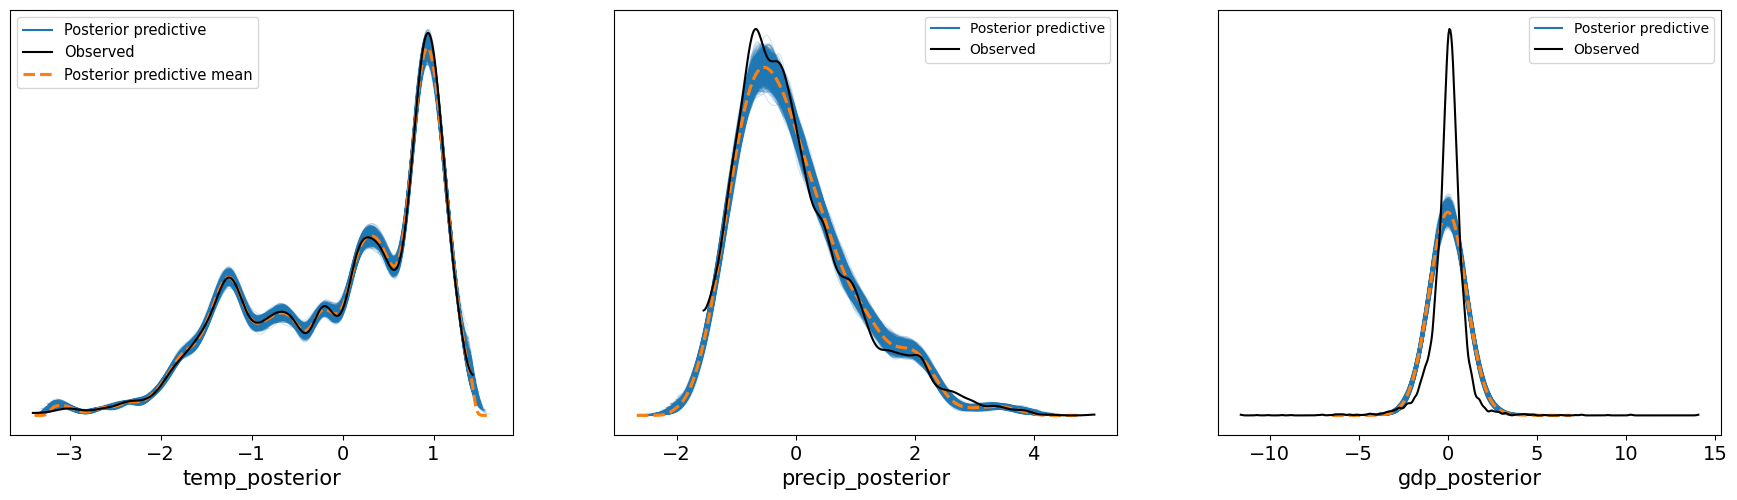

In [5]:
fig = az.plot_ppc(posterior,var_names=["temp_posterior","precip_posterior","gdp_posterior"]).ravel()[0].figure
fig.show()

/tmp/ipykernel_10400/1883471754.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


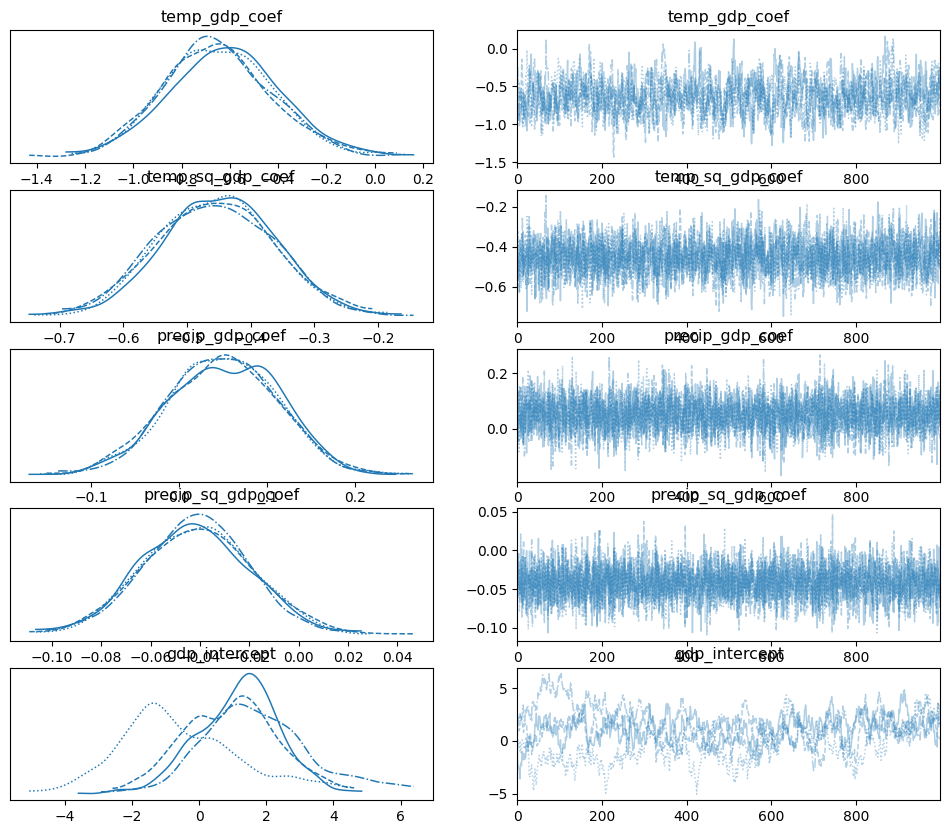

In [6]:
fig = az.plot_trace(trace, var_names=["temp_gdp_coef","temp_sq_gdp_coef","precip_gdp_coef","precip_sq_gdp_coef","gdp_intercept"]).ravel()[0].figure
fig.show()

In [25]:
print(np.mean(trace.posterior.temp_gdp_coef.data))
print(np.mean(trace.posterior.temp_sq_gdp_coef.data))
print(np.mean(trace.posterior.precip_gdp_coef.data))
print(np.mean(trace.posterior.precip_sq_gdp_coef.data))
print(np.mean(trace.posterior.gdp_intercept.data))

-0.4339694863402706
-0.3836364766147224
0.20378154208861973
-0.09710523813636335
-4.242840607816269


# Confirm that unscaled samples lead to correct coefficients

In [7]:
precip_data = precip_scaler.inverse_transform(np.array(posterior.posterior_predictive.precip_posterior.data.flatten()).reshape(-1,1))
gdp_data = gdp_scaler.inverse_transform(np.array(posterior.posterior_predictive.gdp_posterior.data.flatten()).reshape(-1,1))
temp_data = temp_scaler.inverse_transform(np.array(posterior.posterior_predictive.temp_posterior.data.flatten()).reshape(-1,1))
X = np.column_stack((
    temp_data,
    np.square(temp_data),
    precip_data,
    np.square(precip_data)
))
linreg = LinearRegression().fit(X,gdp_data)
print(linreg.coef_)
print(linreg.intercept_)

[[ 9.99298768e-04 -5.12538947e-05  4.16911114e-06 -3.78482995e-10]]
[0.01624184]


# Reproduce 13C threshold with probabilistic model

In [8]:
og_coef1 = linreg.coef_[0][0]
og_coef2 = linreg.coef_[0][1]
og_coef3 = linreg.coef_[0][2]
og_coef4 = linreg.coef_[0][3]
coef1 = trace.posterior.temp_gdp_coef.data.flatten()
coef2 = trace.posterior.temp_sq_gdp_coef.data.flatten()
coef3 = trace.posterior.precip_gdp_coef.data.flatten()
coef4 = trace.posterior.precip_sq_gdp_coef.data.flatten()
mult1 = og_coef1/np.mean(coef1)
mult2 = og_coef2/np.mean(coef2)
mult3 = og_coef3/np.mean(coef3)
mult4 = og_coef4/np.mean(coef4)
numerator = [val*mult1 for val in coef1]
denominator = [-2*val*mult2 for val in coef2]
res = np.array(numerator) / np.array(denominator)

In [9]:
print(np.mean(res), np.mean(res) - np.std(res), np.mean(res) + np.std(res))

9.75886328388811 6.59063325000033 12.927093317775888


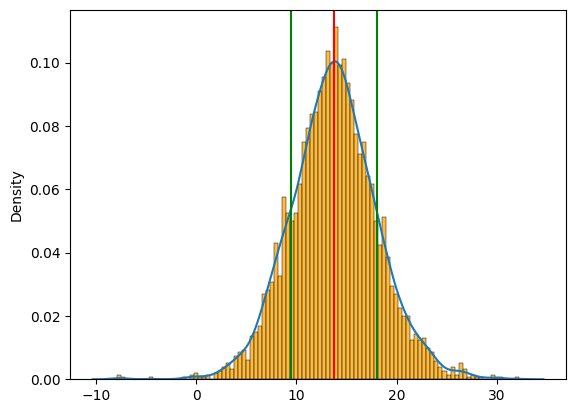

In [147]:
x = np.linspace(np.mean(res) - 3*np.std(res), np.mean(res) + 3*np.std(res), 100)
sns.histplot(res,bins=100,color="orange",stat="density")
# plt.plot(x, stats.norm.pdf(x, np.mean(res), np.std(res)), color="blue")
sns.kdeplot(res)
plt.axvline(x = np.mean(res), color = 'r', label = 'axvline - full height')
plt.axvline(x = np.mean(res) - np.std(res), color = 'g', label = 'axvline - full height')
plt.axvline(x = np.mean(res) + np.std(res), color = 'g', label = 'axvline - full height')
plt.savefig("../figures/burke_reproduction_pdf.png")

# Scaled coefs for error estimation

In [10]:
print(np.mean(mult1*coef1))
print(np.std(mult1*coef1))
print(np.mean(mult2*coef2))
print(np.std(mult2*coef2))
print(np.mean(mult3*coef3))
print(np.std(mult3*coef3))
print(np.mean(mult4*coef4))
print(np.std(mult4*coef4))

0.0009992987682286047
0.0003539394893837055
-5.1253894660406745e-05
1.0137098523300436e-05
4.16911114081315e-06
5.192943994516138e-06
-3.784829953989272e-10
2.0221372426588823e-10


# Burke et al. Uncertainty Bounds

In [120]:
burke_temp_coef = .0127183
burke_temp2_coef = -.0004871
burke_temp_error = .0037876
burke_temp2_error = .0001184

lower_bound = (burke_temp_coef - burke_temp_error ) / (-2 * (burke_temp2_coef - burke_temp2_error))
upper_bound = (burke_temp_coef + burke_temp_error ) / (-2 * (burke_temp2_coef + burke_temp2_error))
mean = burke_temp_coef / (-2 * burke_temp2_coef)
print(lower_bound)
print(upper_bound)
print(mean)

7.374649050371593
22.383916463249253
13.05512215150893
